# A/B Testing Project - Ecommerce landing page data

The dataset was obtained from Kaggle. It has the A/B testing result of the new landing page design (old design vs new design).
The current conversion rate is around 13% on average , and it could be better if we get 2% increase from the new design.

## Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
import statsmodels.stats.api as sms
from math import ceil

## Formulating the hypothesis
Since we are not sure if the new design of landing page performed better or not, we will use a two-tailed test where p and p0 stand for the conversion rate of new and old design respectively. The confidence level for this test will be 95% or α = 0.05.

- H0: p = p0
- H1: p ≠ p0

## Choosing variables

We will set two groups for this test, independent variable and dependent variable.

##### Independent variable
The independent variable will be represented by **control** column that contains 2 groups:
- Control group: users in this group will be shown the old design of landing page.
- Treatment group: users in this group will be shown the new design of landing page.

##### Dependent variable (the thing that we try to measure)
It will be represented by **converted** column that contains 2 unique values:
- 0: it indicates that the user did not make a purchase on the landing page.
- 1: it indicates that the user made a purchase on the landing page.

## Sample size

For choosing the correct sample size of this study, we will apply **power analysis** method and it has few requirements to meet:
- Power of the test (1 — β): It indicates the probability of finding the statistical difference between groups in our test. The standard for the power test is 0.8 .
- Alpha value (α): 0.05 or 95% confidence level.
- Effect size: The difference we expect from old (13%) and new (15%) conversion rate.

In [22]:
# Calculate the effect size based on our expected conversion rate.
effect_size = sms.proportion_effectsize(0.13, 0.15)

# Calculate the sample size needed.
required_n = sms.NormalIndPower().solve_power(effect_size, power = 0.8, alpha = 0.05, ratio = 1)
required_n = ceil(required_n)

required_n
# The sample size we need for this study is 4720.

4720

## Check out the data
We'll  work with the ab_data csv data from kaggle. It has 5 columns:
1. user_id - The user ID of each session
2. timestamp - Timestamp for the session
3. group - Which group the user was assigned to for that session (control, treatment)
4. landing_page - Which design each user saw on that session (old_page, new_page)
5. converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
df.info()
# 294478 rows and 5 columns, no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [13]:
# Let's see if all users in the control group are seeing the old page and vice versa.
pd.crosstab(df['group'], df['landing_page'])

# There are some users on the assigned group that are seeing the wrong page (1928 and 1965 from each group)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [17]:
# Let's make sure if no users that have been sampled multiple times.
session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()
multi_users

# There are 3894 users that appear more than once, we will remove them in the next step.

3894

In [20]:
users_to_drop = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(users_to_drop)]
df.shape

# Now, the updated dataset has 286690 rows.

(286690, 5)

## Sampling

Now is the time to sampling the dataset to required sample size that we calculated before (required_n, 4720). The random_state used in this sampling calculation will be 22.

In [23]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state = 22)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state = 22)

ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test

,user_id,timestamp,group,landing_page,converted
186628,763854,2017-01-21 03:43:17.188315,control,old_page,0
57904,690555,2017-01-18 06:38:13.079449,control,old_page,0
13276,861520,2017-01-06 21:13:40.044766,control,old_page,0
228415,630778,2017-01-05 16:42:36.995204,control,old_page,0
96065,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
46153,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
235886,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
268794,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
190461,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [24]:
ab_test.info()
# 9440 rows and 5 columns, no missing data.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9440 entries, 186628 to 244926
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 442.5+ KB


In [26]:
# Let's check again if all users in the control group are seeing the old page and vice versa.
pd.crosstab(ab_test['group'], ab_test['landing_page'])

# No problem, well done!

landing_page,new_page,old_page
group,,
control,0,4720
treatment,4720,0


## Visualize the result
First, let's do some calculations to know what our samplings look like.

In [38]:
# Std. deviation of the proportion
std_p = lambda x: np.std(x,  ddof = 0)

#Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x, ddof = 0)

conversion_rates = ab_test.groupby('group')['converted']
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.123305,0.328787,0.004786
treatment,0.125636,0.331438,0.004824


(0.0, 0.17)

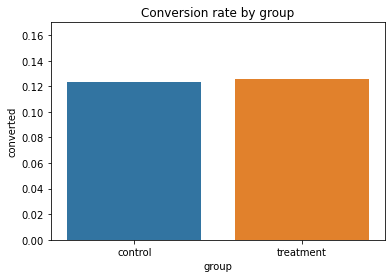

In [45]:
sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci = False)
plt.title('Conversion rate by group')
plt.ylim(0, 0.17)


Judging by the result above, the two designs of the landing page performed similarly, but the new design performed slighly better (**12.3%** vs **12.6%**)

## Hypothesis testing
This is the last step of our test and we will use the normal approximation to calculate the p-value (z-test) since we got a very large sample size.

In [47]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [48]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [50]:
n_con = control_results.count()
n_treat = treatment_results.count()
success = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]


z_stat, pval = proportions_ztest(success, nobs = nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(success, nobs = nobs, alpha = 0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


## Conclusion
The result of our test indicates that the performance of the new design of the landing page is not significant different than the old one (shown by p-value = 0.732 that is below 95% or α = 0.05).

Moreover, if we look at the confidence interval of the **treatment** group (11.6% to 13.5%), it includes the conversion rate of the old design that is 13% and not 15% as we expected. It proves that the new design is not likely to be an improvement from the old one.

## Great Job!
Congrats on our work! Hope the company loves the insights!